In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
import xlrd
import openpyxl
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import math
import _pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium
from folium.plugins import HeatMap

/Users/tomo/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
with open("pkls/r6_pq.pkl", "rb") as f:
    a = _pickle.load(f)
with open("pkls/list_item.pkl", "rb") as f:
    list_item = _pickle.load(f)
with open("pkls/m3_list.pkl", "rb") as f:
    m3_list = _pickle.load(f)

In [3]:
import re  # 正規表現によるパターンマッチ

def meshcode_to_latlng(code, loc = 'C'):

	if type(code) != int:  # 整数型に（文字列が渡された場合に対応）
		try:
			code = int(code)
		except:  # 形式チェック
			print("Error in  mesh_lib.meshocode_to_latlong()  Not a valid code handed.")
			raise

	code = str(code) # あらためて文字型に。

	code12 = ''
	code34 = ''
	code5  = ''
	code6  = ''
	code7  = ''
	code8  = ''

	loc = loc.upper()

	if re.match("^C|(NE)|(NW)|(SE)|(SW)$", loc) == None:
		raise Exception ("Invalid option to meshcode_to_latlong()")

	match_1_result = re.match("\d{4}", code)

	if re.match("\d{4}", code):  # 最初の４文字が数字

		code12 = code[0:2]
		code34 = code[2:4]
		lat_width  = 2.0 / 3.0  # grid cell の緯度方向の間隔
		long_width = 1.0        # grid cell の経度方向の間隔

	else:
		return (None)           # メッシュコードとして無効

	if re.match("\d{6}", code):   # 少なくとも最初の６文字は数字

		code5 = code[4:5]
		code6 = code[5:6]
		lat_width  /= 8.0;
		long_width /= 8.0;

	if re.match("\d{8}", code):  # 最初の８文字は数字

		code7 = code[6:7]
		code8 = code[7:8]
		lat_width  /= 10.0;
		long_width /= 10.0;

    # 以下、南西コーナーの座標を求める。

	lat  = float(code12) * 2 / 3          #  一次メッシュ
	long = float(code34) + 100

	if (code5 != '') & (code6 != ''):     # 二次メッシュ or 三次メッシュ
		lat  += (float(code5) * 2 / 3) / 8
		long += float(code6) / 8 

	if (code7 != '') & (code8 != ''):     # 三次メッシュ
		lat  += float(code7) * 2 / 3 / 8 / 10
		long += float(code8) / 8 / 10 

	# ここまでで南東端の緯度・経度が得られた

	# 中央の座標なら、一区画の幅（経度幅）・高さ（緯度幅）の半分を足す。
	if loc == 'C':
		lat  += lat_width  / 2 
		long += long_width / 2

	# 北端の座標なら、一区画の高さ（緯度幅）を足す
	if re.search('N', loc):
		lat += lat_width

	# 東端の座標なら、一区画の幅（経度幅）を足す
	if re.search('E', loc):
		long  += long_width

	return (lat, long)     # タプルを返す。

In [4]:
gau_P_m3 = pd.DataFrame(a["P"] ,columns=m3_list, index=list('123456'))
gau_P_m3_T = gau_P_m3.T
m3_lat = []
m3_lng = []
for index, row in gau_P_m3_T.iterrows():
    mlat, mlng = meshcode_to_latlng(index, "SW")
    mlat = mlat + 15 / 3600
    mlng = mlng + 22.5 / 3600
    m3_lat.append(mlat)
    m3_lng.append(mlng)
    
tmp_m3_latlng = pd.DataFrame([m3_lat, m3_lng], columns=gau_P_m3_T.index).T
gau_P_m3_T_latlng = gau_P_m3_T.join(tmp_m3_latlng)
gau_P_m3_T_latlng.columns = [1,2,3,4,5,6,'lat','lng']


## Heatmap

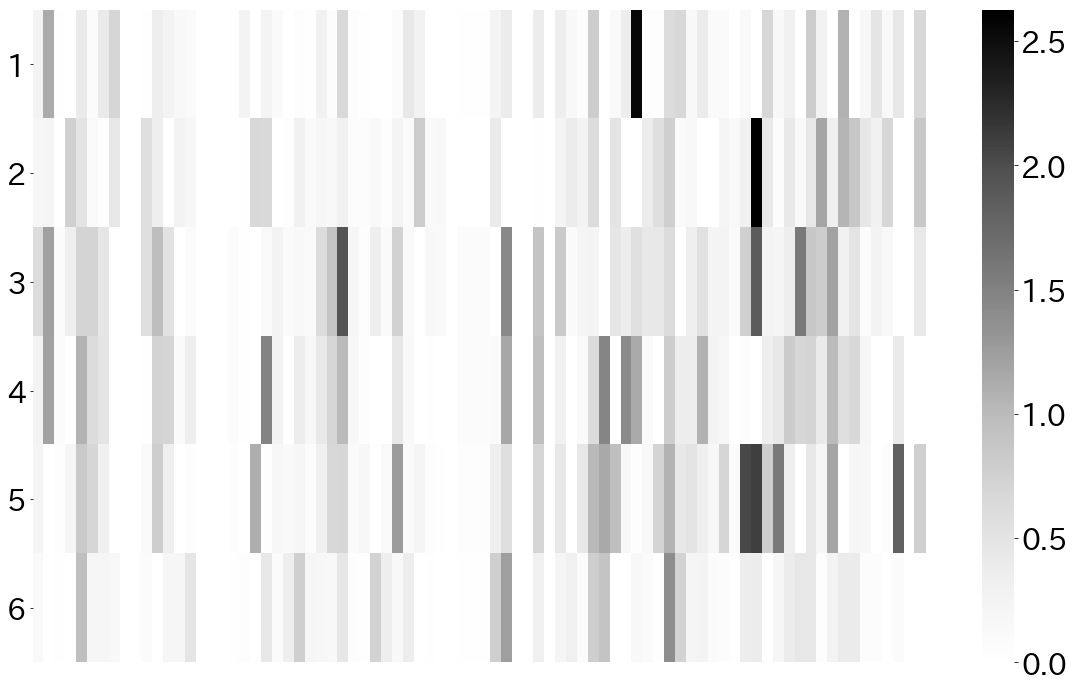

In [62]:
plt.rcParams['font.family'] = 'IPAPGothic' #全体のフォントを設定
plt.rcParams["figure.figsize"] = [20, 12] # グラフのサイズを指定
plt.rcParams['font.size'] = 20 #フォントサイズを設定 default : 12
plt.rcParams['xtick.labelsize'] = 30 # 横軸のフォントサイズ
plt.rcParams['ytick.labelsize'] = 30 # 縦軸のフォントサイズ
region_hm_tmp = sns.heatmap(a["P"], xticklabels=False, yticklabels=['1', '2', '3', '4', '5', '6'], cmap='Greys')
region_hm_tmp.set_yticklabels(yticklabels, rotation=0)
region_hm_tmp.subplots_adjust = (0.1, 0.8)
region_hm_tmp.figure.savefig('region_hm8.eps', bbox_inches="tight")

In [54]:
data = a["Q"]

# 比較的簡単なpointplotを使う
ax = sns.pointplot(
    x='ざんさんの種類',   # x軸にDateTime
    y='ランク数')   # dataをplotするマーカーを非表示に

# x軸方向のデータが多すぎるので1日毎にラベルを間引く（データは間引かない）
xlabels = list_item

# x軸ラベルを設定＆ラベル表示を90度回転
ax.set_xticklabels(list_item, rotation='vertical')

# pngファイルに書き出す
sns.heatmap(a["Q"], yticklabels=['1', '2', '3', '4', '5', '6'], cmap='Greys')

ValueError: Could not interpret input 'ざんさんの種類'

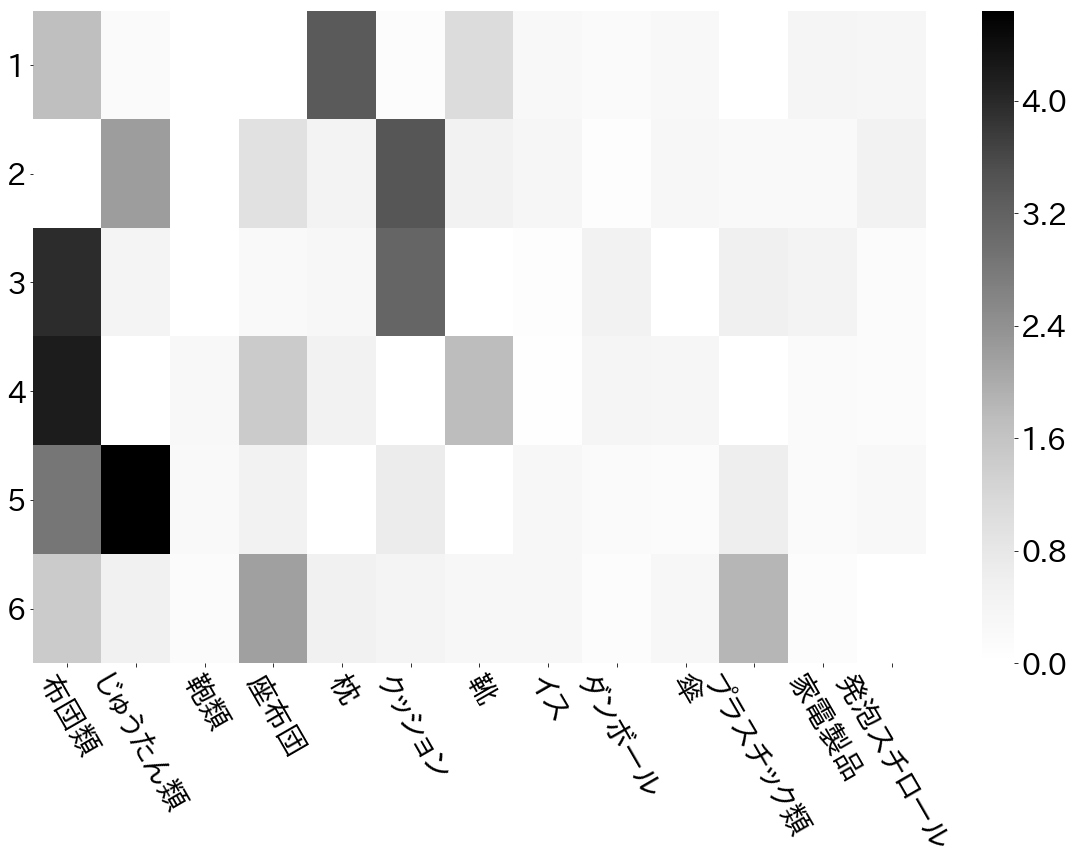

In [61]:
plt.rcParams['font.family'] = 'IPAPGothic' #全体のフォントを設定
plt.rcParams["figure.figsize"] = [20, 12] # グラフのサイズを指定
plt.rcParams['font.size'] = 20 #フォントサイズを設定 default : 12
plt.rcParams['xtick.labelsize'] = 30 # 横軸のフォントサイズ
plt.rcParams['ytick.labelsize'] = 30 # 縦軸のフォントサイズ
# 比較的簡単なpointplotを使う
yticklabels=['1', '2', '3', '4', '5', '6']
kind_hm_tmp = sns.heatmap(a["Q"],xticklabels=list_item, yticklabels=['1', '2', '3', '4', '5', '6'], cmap='Greys')
kind_hm_tmp.set_xticklabels(list_item, rotation=300)
kind_hm_tmp.set_yticklabels(yticklabels, rotation=0)
# region_hm_tmp.subplots_adjust = (0.1, 0.8)
kind_hm_tmp.figure.savefig('kind_hm8.eps', bbox_inches="tight")
# plt.savefig('resultk6_kind.png')

In [7]:
list_item

['布団類',
 'じゅうたん類',
 '鞄類',
 '座布団',
 '枕',
 'クッション',
 '靴',
 'イス',
 'ダンボール',
 '傘',
 'プラスチック類',
 '家電製品',
 '発泡スチロール']

In [7]:
list_item

['布団類',
 'じゅうたん類',
 '鞄類',
 '座布団',
 '枕',
 'クッション',
 '靴',
 'イス',
 'ダンボール',
 '傘',
 'プラスチック類',
 '家電製品',
 '発泡スチロール']

### クラスタリング

In [8]:
def clustering(C):
    pred = KMeans(n_clusters=C).fit_predict(a["P"].T)
    print(pred)
    gau_P_m3_T_latlng['cluster_id']=pred
    print(gau_P_m3_T_latlng['cluster_id'].value_counts())

    clusterinfo = pd.DataFrame()
    for i in range(C):
        clusterinfo['cluster' + str(i)] = gau_P_m3_T_latlng[gau_P_m3_T_latlng['cluster_id']==i].mean()
    clusterinfo = clusterinfo.drop('cluster_id')
    clusterinfo = clusterinfo.drop('lat')
    clusterinfo = clusterinfo.drop('lng')

    plot1 = clusterinfo.T.plot(kind='bar', stacked=True, title="Mean Value of 4 Clusters")
    plot1.set_xticklabels(plot1.xaxis.get_majorticklabels(), rotation=0)
        
    gau_latlng_C = []
    for i in range(C):
        gau_latlng_C.append(gau_P_m3_T_latlng[gau_P_m3_T_latlng.cluster_id == i])
    
    with open('gau_clustering_data_{}.pkl'.format(C), 'wb') as f:
        _pickle.dump(gau_P_m3_T_latlng, f)
        
    return gau_latlng_C, clusterinfo

[4 2 1 4 2 6 6 4 1 1 4 2 6 1 1 1 1 1 1 1 4 6 1 1 6 1 6 6 2 1 1 1 1 0 1 4 1
 1 1 1 1 1 4 2 1 1 2 1 6 1 4 6 6 4 6 5 4 4 2 6 6 6 1 4 1 0 3 4 0 6 2 2 4 2
 4 6 4 1 4 0 1 4]
1    32
4    18
6    16
2    10
0     4
5     1
3     1
Name: cluster_id, dtype: int64


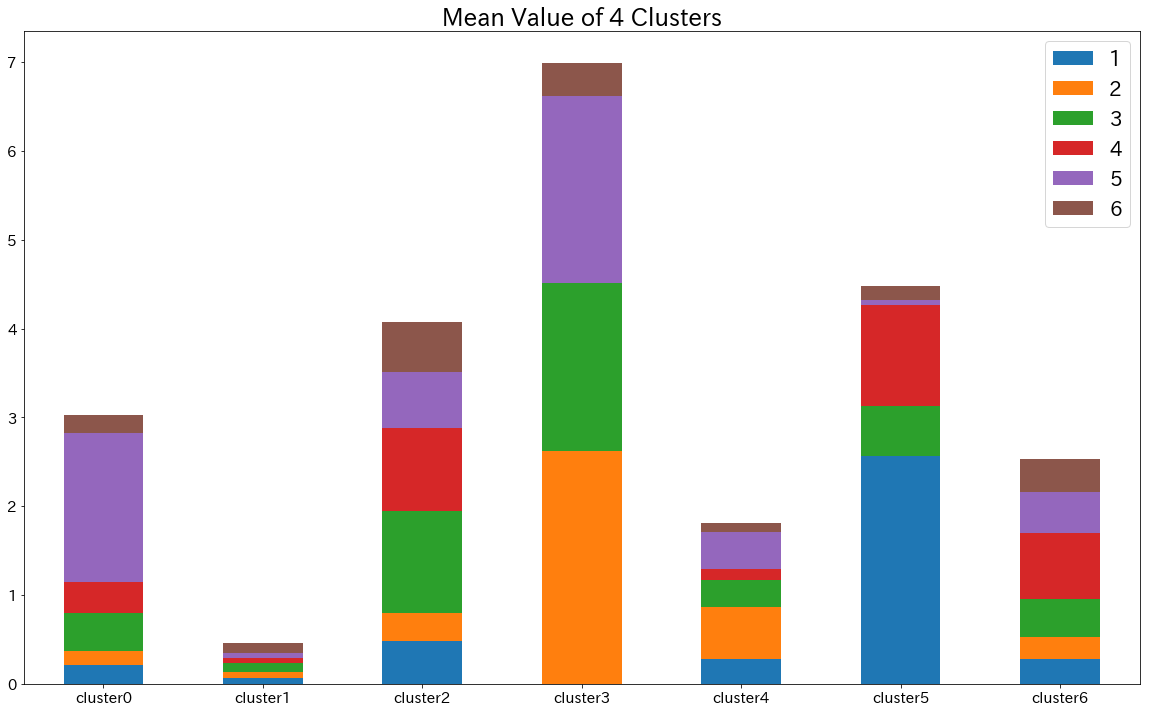

In [9]:
gau_latlng_C, A = clustering(7)

In [10]:
# # Create a simple stock Leaflet marker on the map
# center = [35.37,139.47]
# map0_1 = folium.Map(location=center, zoom_start=12)
# for i in range(len(gau_latlng_C[0].index)):
#     marker_latlng = [gau_latlng_C[0].at[gau_latlng_C[0].index.values[i],'lat'], gau_latlng_C[0].at[gau_latlng_C[0].index.values[i],'lng']]
#     marker = folium.Marker(marker_latlng)
#     map0_1.add_child(marker)
# map0_1

In [11]:
# # まとめてヒートマップ を表示しようとしたやつ
# def mapping(cn):
#     center = [35.37,139.47]
#     for j in range(cn):
#         hmap = folium.Map(location=center, zoom_start=12)
#         marker_list = []
#         for i in range(len(gau_latlng_C[j].index)):
#             marker_latlng = [gau_latlng_C[j].at[gau_latlng_C[j].index.values[i],'lat'], gau_latlng_C[j].at[gau_latlng_C[j].index.values[i],'lng']]
#             marker_list.append(marker_latlng)
#         hmarker = HeatMap(marker_list)
#         hmap.add_child(hmarker)
#         return hmap

In [12]:
def mapping(cn, hm=None):
# Create a Heatmap marker on the map
    center = [35.37,139.47]
    hmap = folium.Map(location=center, zoom_start=12)
    marker_list = []
    df = gau_latlng_C[cn]
    for i in range(len(df.index)):
        if hm == None:
            marker_latlng = [df.at[df.index.values[i],'lat'], df.at[df.index.values[i],'lng']]
            input_list = marker_latlng
        else:
            marker_latlngx = [df.at[df.index.values[i],'lat'], df.at[df.index.values[i],'lng'], df.loc[df.index.values[i], hm]]
            input_list = marker_latlngx
        marker_list.append(input_list)
#     if hm == None:
#         hmarker = HeatMap(marker_list)
#     else:
#         hmarker = HeatMap(marker_list, max_zoom=13, radius=40, blur=18)
    hmarker = HeatMap(marker_list)
    hmap.add_child(hmarker)
    return hmap

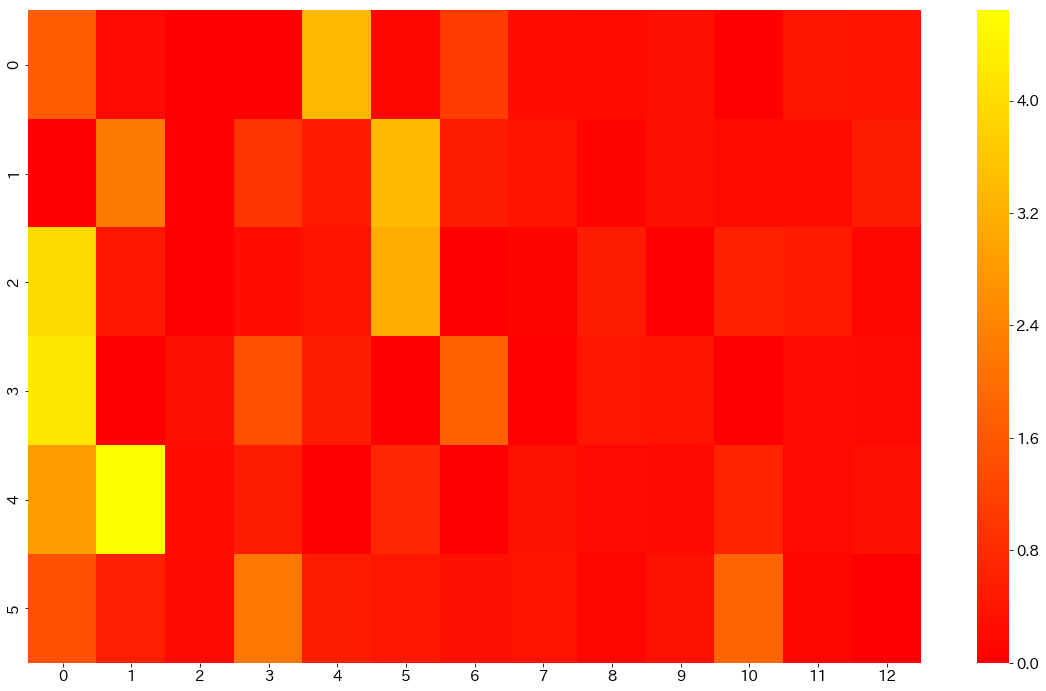

In [13]:
sns.heatmap(a["Q"], cmap='autumn')

In [14]:
list_item

['布団類',
 'じゅうたん類',
 '鞄類',
 '座布団',
 '枕',
 'クッション',
 '靴',
 'イス',
 'ダンボール',
 '傘',
 'プラスチック類',
 '家電製品',
 '発泡スチロール']

In [15]:
mapping(0)

In [16]:
mapping(1)

In [17]:
mapping(2)

In [18]:
mapping(3)

In [19]:
mapping(4, 5)

In [20]:
mapping(5)

In [21]:
mapping(6)

In [22]:
# # Create a Heatmap marker on the map
# center = [35.37,139.47]
# hmap = folium.Map(location=center, zoom_start=12)
# marker_list = []
# x = 5
# for i in range(len(gau_latlng_C[4].index)):
#     marker_latlng = [gau_latlng_C[4].at[gau_latlng_C[4].index.values[i],'lat'], gau_latlng_C[4].at[gau_latlng_C[4].index.values[i],'lng']]
# #     marker_latlngx = [gau_latlng_C[4].at[gau_latlng_C[4].index.values[i],'lat'], gau_latlng_C[4].at[gau_latlng_C[4].index.values[i],'lng'], gau_latlng_C[4].loc[gau_latlng_C[4].index.values[i], x]]
#     marker_list.append(marker_latlng)
# hmarker = HeatMap(marker_list)
# hmap1.add_child(hmarker)
# hmap1

In [23]:
#for i in range(7):
# print(gau_latlng_C[0][2])
for row in gau_latlng_C[0].iterrows():
    print(row[1].lat.values[0])
# len(gau_latlng_C[0][2])
# print(gau_latlng_C[0][gau_latlng_C[0].])

AttributeError: 'numpy.float64' object has no attribute 'values'

In [ ]:
gau_latlng_C[2].loc[gau_latlng_C[2].index.values[0], 5]

In [ ]:
gau_latlng_C[2]